# PUI 2017 HW 10
## Yuwen Chang (ywc249)
### Data
- [MTA subway fares](https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy)

### Objective
- Find outliers, trends and periodicity in the MTA turnstile data.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
url = 'https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy'
os.system('curl -O ' + url)
os.system('mv MTA_Fare.npy ' + os.getenv('PUIDATA'))
mtaRides = np.load(os.getenv('PUIDATA') + '/MTA_Fare.npy')
mtaRides.shape

(600, 23, 194)

# Task 1: Event detection
## Identify the most prominent event, figure out the date and what it is due to.

In [3]:
# convert missing values (-1) to NaN
mtaNaN = mtaRides.astype(float)
for i in range(600):
    for j in range(23):
        mtaNaN[i][j][mtaNaN[i][j] == -1] = numpy.nan

In [4]:
# collapse ride types, create sums for each station and each week
sum_station = np.nansum(mtaNaN, axis=1)
print(sum_station.shape)

# collapse stations, create sums for each week
sum_week = np.nansum(sum_station, axis=0)
print(sum_week.shape)

(600, 194)
(194,)


In [5]:
# define thresholds for anomaly detection
week_mean = np.nanmean(sum_week)
week_std = np.nanstd(sum_week)

thresholds = [week_mean + 3 * week_std, 
              week_mean - 3 * week_std]

print ("mean swipes by week {:.2f}".format(week_mean))
print ("stdev swipes by week {:.2f}".format(week_std))
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by week 29781349.87
stdev swipes by week 2983960.42
3-sigma thresholds 38733231.14 20829468.61


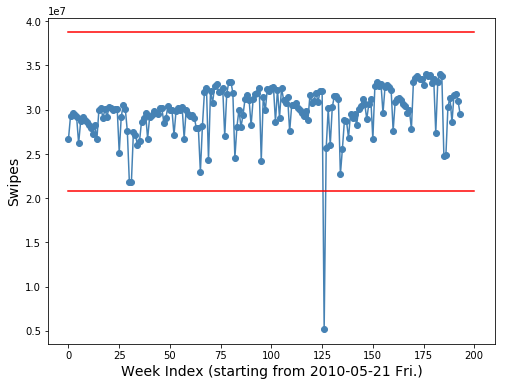

In [6]:
pl.figure(figsize=(8,6))
pl.plot(range(194), (sum_week), '-o', c='steelblue')
pl.plot([0,200], [thresholds[0],thresholds[0]], 'r-')
pl.plot([0,200], [thresholds[1],thresholds[1]], 'r-')
pl.xlabel('Week Index (starting from 2010-05-21 Fri.)', fontsize=14)
pl.ylabel('Swipes', fontsize=14)

## Fig 1. Time trend of weekly MTA swipes from 2010-05-21 to 2014-02-21
The anomaly event that exceeds 3-std occurs around the 125th week in the data.

In [7]:
# locate anomaly (week with swips below threshold)
np.where(sum_week < thresholds[1])

(array([126]),)

In [8]:
# create date range
dates = pd.date_range('2010-05-21', '2014-02-21')
print('The first day of week index 126 is %s'%dates[126*7].date())

The first day of week index 126 is 2012-10-19


## Results

Data:
- Duration: 194 weeks
- Start Date: 2010-05-21 (Fri)
- End Date: 2014-02-21 (Fri)

Event: MTA Service Interruption during Hurricane Sandy
- 10/28 (Sun): MTA shut down.
- 10/29 (Mon): MTA tubes flooded.
- 11/5 (Mon): Major services restored.

Major week affected:
- Week index: 126
- 10/26 (Fri) - 11/2 (Fri)

> Update 10/28, 10:50: Governor Cuomo just announced that all MTA service will be shut down starting at 7 p.m. tonight. Full details from the MTA are at the bottom of this post.
[Source](https://www.huffingtonpost.com/2012/10/30/new-york-city-subway-flooding-_n_2043710.html)


> The system recovered in time for Monday’s morning commute.
[Source](http://nymag.com/daily/intelligencer/2012/11/how-did-the-mta-restore-subway-service.html)

## The corresponding date for the week index should be adjusted one week later (i.e., starting from 2010-05-28 instead).

# Task 2: Trend Detection
## Identify the **ridership types**  that have steadily increased/decreased in popularity, by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [9]:
# collapse stations, create sums for each ride type and each week
sum_type = np.nansum(mtaNaN, axis=0)
print(sum_type.shape)

(23, 194)


In [10]:
# collapse weeks, create sums for each station
sum_station_only = np.nansum(sum_station, axis=1)
print(sum_station_only.shape)

(600,)


In [11]:
# collapse stations, create averages for each ride type and each week
# weight average by sum swipes of each station
avg_type = np.average(mtaRides, weights=sum_station_only, axis=0)
print(avg_type.shape)

(23, 194)


In [12]:
# transform arrays to dataframe
df2 = pd.DataFrame(avg_type).T
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,56334.073271,2572.081408,201.252840,819.862719,337.804064,16203.125046,42567.473379,43.945905,1975.384626,2272.498328,...,874.690492,3512.161344,365.200525,156.234797,-0.001519,470.441560,46.349497,14.041629,0.939432,-1.0
1,61777.395473,2850.923568,217.825649,874.935467,465.488412,17344.642679,47610.126128,51.942965,1629.286859,2600.419256,...,1078.113828,4037.558123,421.764044,179.009937,-0.002707,467.045496,47.834564,13.922451,1.241602,-1.0
2,63188.221007,2864.667920,219.480465,877.692770,415.970179,17612.572114,47657.953965,53.964896,1743.894598,2794.617566,...,1074.542332,4072.209670,427.367769,180.622960,-0.001217,464.633650,47.318959,14.704346,1.205913,-1.0
3,62274.921266,2731.735423,220.208346,864.881284,273.050307,17575.544120,47478.152446,49.006049,1766.154085,2743.384983,...,1042.106700,4012.224830,415.501604,180.075366,-0.001217,461.270794,47.608223,14.984961,1.258843,-1.0
4,62802.130079,2654.210975,215.734810,858.839679,256.911364,17172.350253,46799.595172,45.839840,1939.811392,2566.293559,...,980.270702,3849.843449,405.598620,176.115649,0.506710,459.831843,44.612844,14.222326,1.174874,-1.0


In [13]:
# define ride types
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
                     'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
                     'umlim','xbus','stud'])
df2.columns = ridetype

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


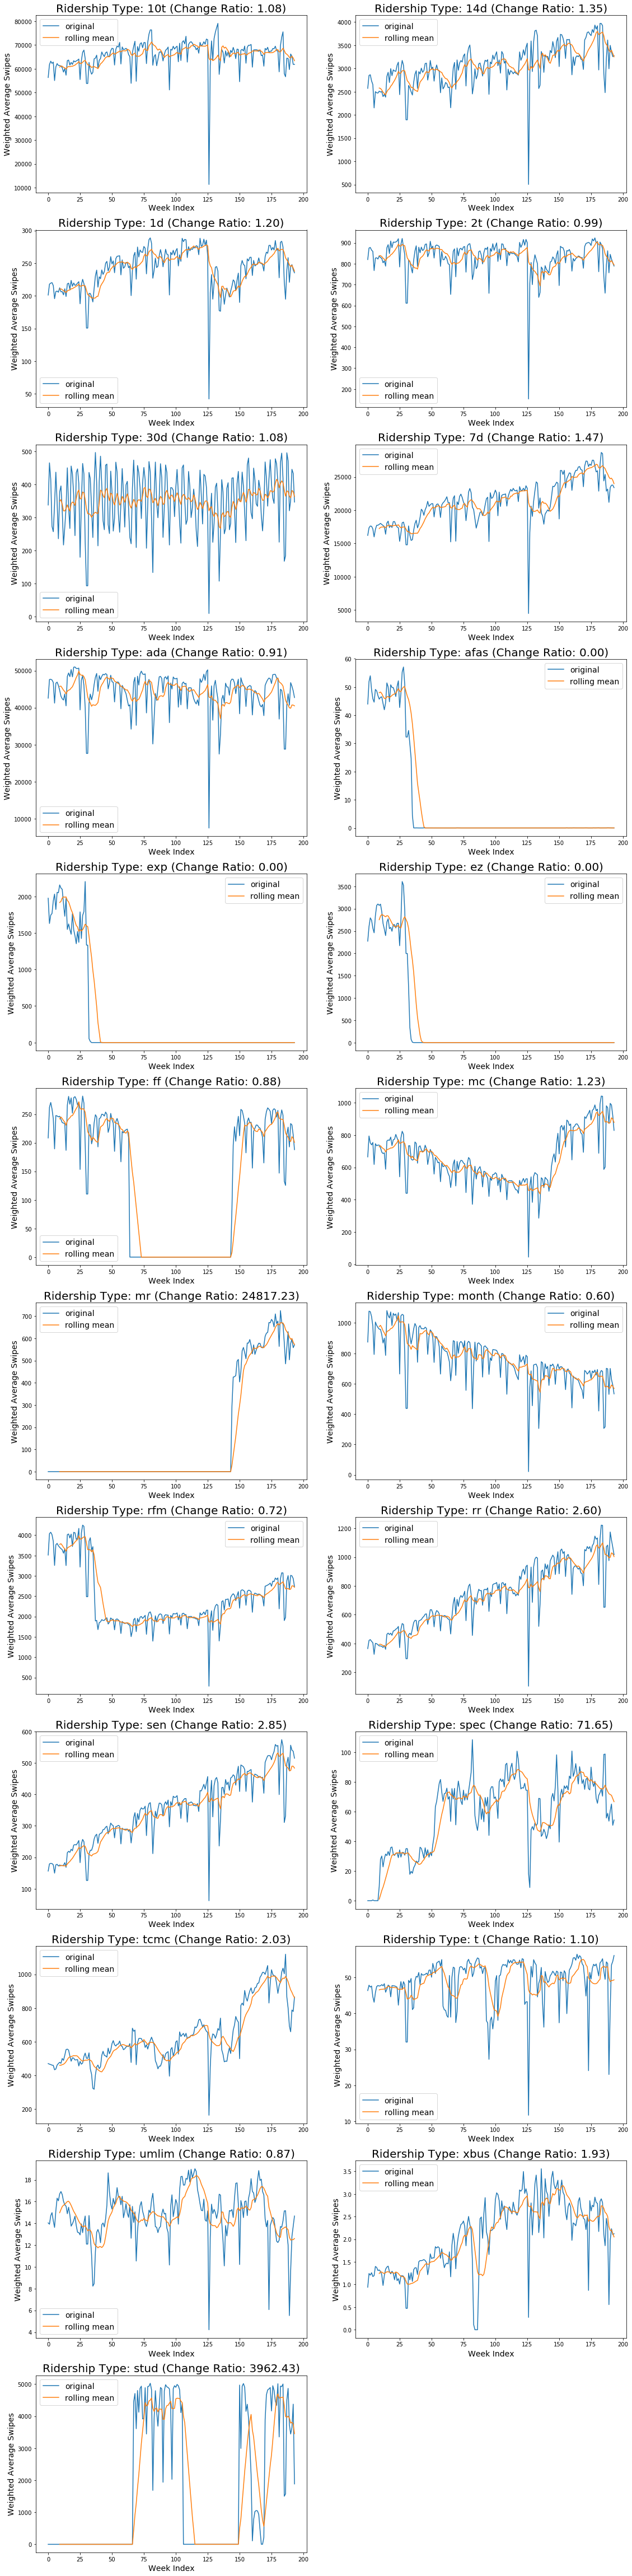

In [14]:
rmeans = []
ratios = []

# plot trendlines for each ride type
fig = pl.figure(figsize=(16,64))

for i,t in enumerate(df2.columns):
    # calculate rolling mean and ratio, with a window of 10
    rmean = pd.rolling_mean(df2[t], 10)
    ratio = np.abs(rmean.tail(10).sum() / rmean.head(10).sum()) / 10
    rmeans.append(rmean)
    ratios.append(ratio)

    ax = fig.add_subplot(12,2,i+1)
    ax.plot(np.arange(len(df2[t])), df2[t], label='original')
    ax.plot(np.arange(len(df2[t])), rmean, label='rolling mean')

    ax.set_title('Ridership Type: %s (Change Ratio: %.2f)'%(t,ratio), fontsize=20)
    ax.set_xlabel('Week Index', fontsize=14)
    ax.set_ylabel('Weighted Average Swipes', fontsize=14)
    ax.legend(fontsize=14)

pl.tight_layout()
pl.show()

## Fig 2. Time series of each ridership type (with rolling-mean-smoothed trendline)
## NOTE: I caculate the ratio inversely (end / beginning) for easier interpretation.
We may observe visually that constant trends take place in the following ridership types:

#### a) increase
- rr (steep)
- sen (steep)
- tcmc (steep)
- 14d
- 7d

#### b) decrease
- month (steep)

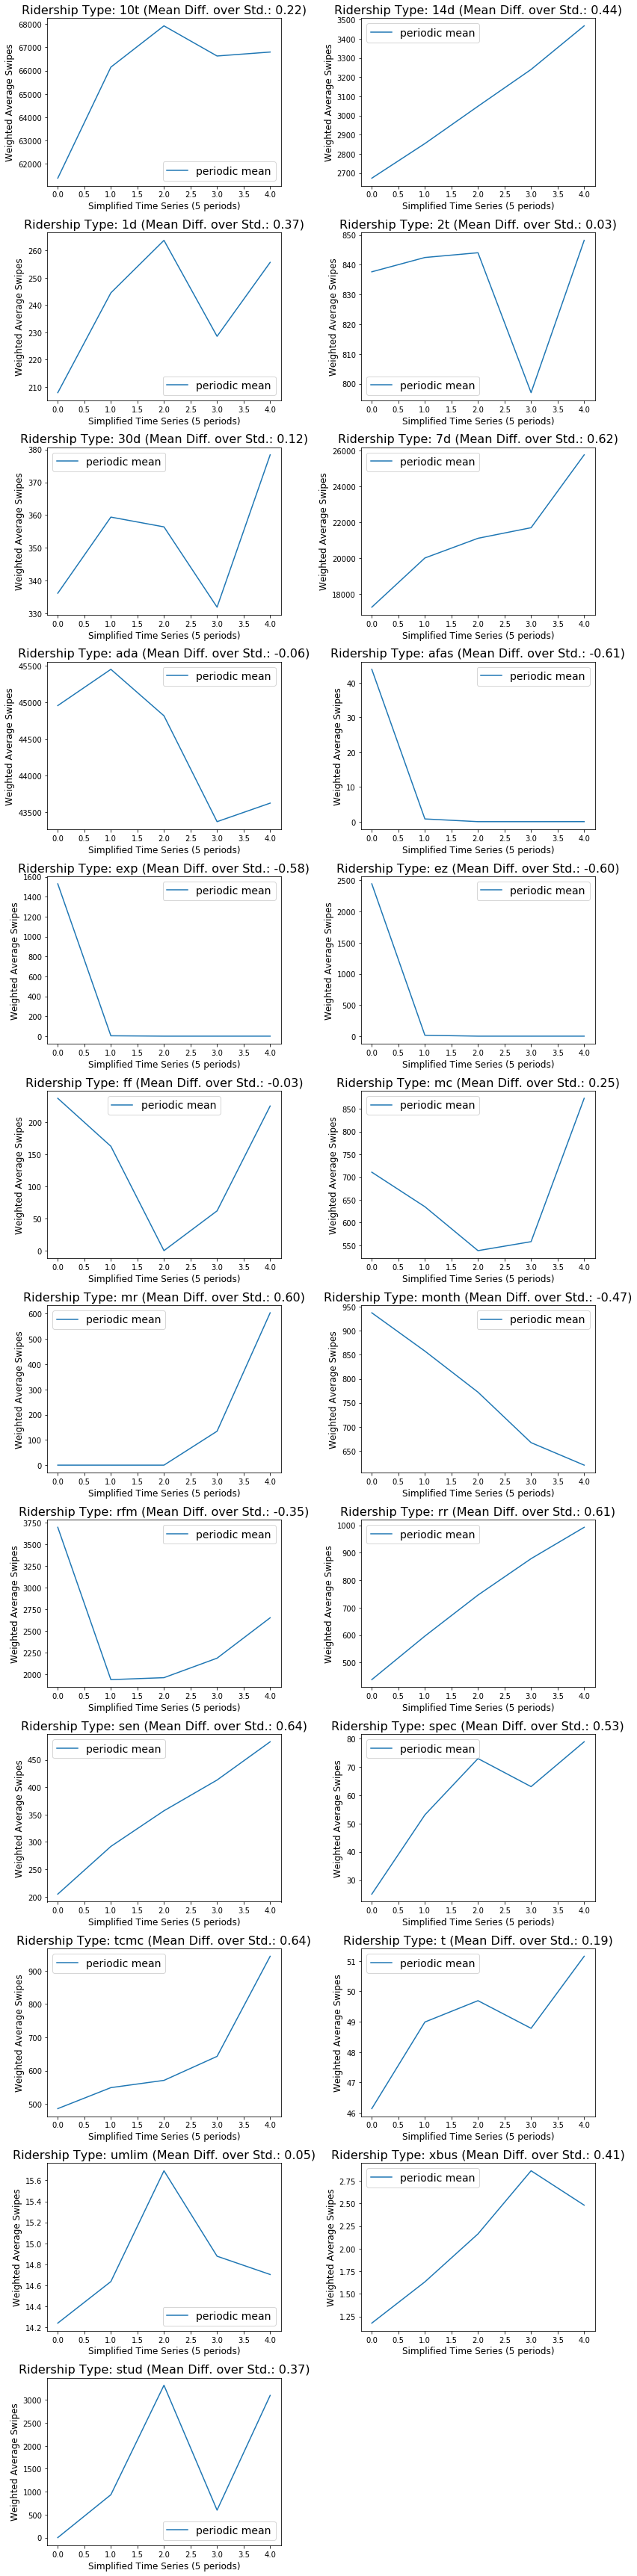

In [15]:
mdiffs = []

# plot periodic means (5 periods) and differences
fig = pl.figure(figsize=(12,48))

for i,t in enumerate(df2.columns):
    # calculate periodic means and differences
    smeans = [rmeans[i][c:c+40].mean() for c in np.arange(0,200,40)]
    diffs = np.diff(smeans)
    mdiff = diffs.mean() / df2[t].std()
    mdiffs.append(mdiff)

    ax = fig.add_subplot(12,2,i+1)
    ax.plot(np.arange(len(smeans)), smeans, label='periodic mean')
    #ax.plot(np.arange(len(diffs))+0.5, diffs, label='difference')

    ax.set_title('Ridership Type: %s (Mean Diff. over Std.: %.2f)'%(t,mdiff), fontsize=16)
    ax.set_xlabel('Simplified Time Series (5 periods)', fontsize=12)
    ax.set_ylabel('Weighted Average Swipes', fontsize=12)
    ax.legend(fontsize=14)

pl.tight_layout()
pl.show()

## Fig 3. Simplified trendlines (5 segments)
The simplified trends show similar results from Fig 2.

In [16]:
# create a dataframe that lists the ratio and mean diff over std for each ride type
df2a = pd.DataFrame([ridetype, ratios, mdiffs]).T
df2a.columns=['type', 'ratio', 'mdiff']
df2a.sort_values(by='mdiff', axis=0, ascending=False)

,type,ratio,mdiff
18,tcmc,2.02828,0.643797
16,sen,2.8529,0.635546
5,7d,1.4717,0.621126
15,rr,2.60367,0.610764
12,mr,24817.2,0.595941
17,spec,71.6489,0.53176
1,14d,1.34844,0.440088
21,xbus,1.92635,0.413255
2,1d,1.19985,0.3716
22,stud,3962.43,0.365205


## Results
### Visual Inspection
From Fig 2. and Fig 3., we may observe visually that constant trends take place in the following ridership types:

#### a) increase
- rr (steep)
- sen (steep)
- tcmc (steep)
- 14d
- 7d

#### b) decrease
- month (steep)

### Ratio
I caculate the ratios inversely (end / beginning) for easier interpretation. I also calculate a mean difference of 5-period mean over the standard deviation for each ridership type so it roughly depicts the changing rate throughout 2010 to 2014.

Sorting by the mean changing rate throughout the 5 periods, we have tcmc, sen, 7d, rr as highest positive, and month as highest negative (excluding those that do not have constant trends), mathcing the visual inspection result. 

The ratios (inverse) are as follow:

Identify the ridership types that have steadily increased/decreased in popularity, by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

- Transit Check Metro Card (tcmc): increase to 2.02 times
- Senior Citizen/Disabled (sen): increase to 2.85 times
- 7 Day (7d): increase to 1.47 times
- Rail Road (rr): increase to 2.60 times
- Monthly (month): decrease to 0.60 times

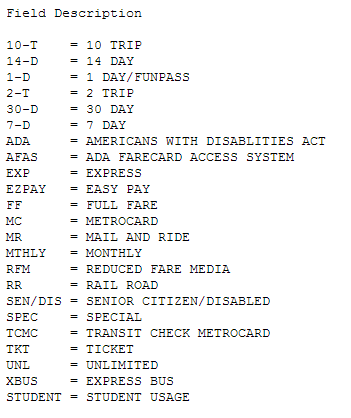

In [17]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

# Task 3: Periodic Trend
## Identify the 4 stations that show the most prominent periodic trend on an annual period (52 weeks). Figure out what the periodic peak in rides is due to.

In [18]:
# transform arrays to dataframe
df3 = pd.DataFrame(sum_station).T
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


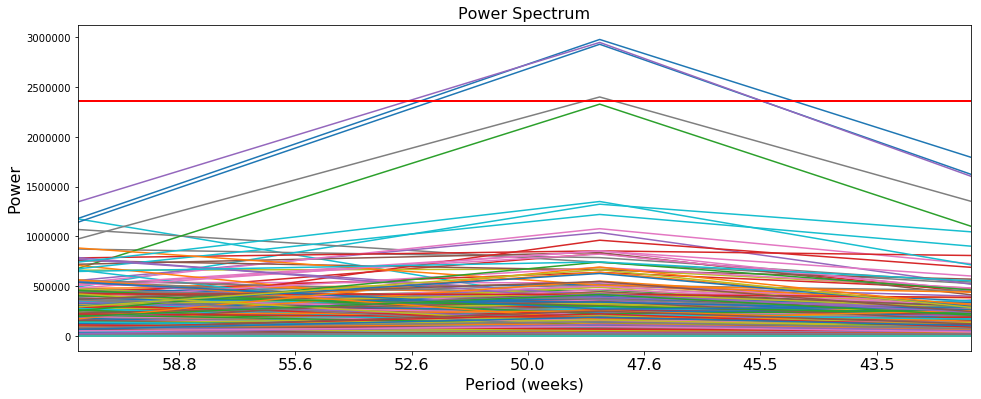

In [23]:
N = len(df3)
peak = []

# plot power spectrum for each station throughout the time series
fig = pl.figure(figsize=(16,6))

for s in df3.columns:
    f = np.abs(np.fft.rfft(df3[s]))
    ax = fig.add_subplot(111)
    
    # record top 4 peaks around week 52
    if f[4] > 2.36e6:
        peak.append(s)
    
    #ax.plot(np.fft.rfftfreq(N, 1)[1:], f[1:], 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1)[1:], f[1:], '-')
    ax.plot((1/62, 1/42), (2.36e6, 2.36e6), 'r-')

    # set zoom-in view
    ax.set_xlim(1/62, 1/42)
    ax.set_xticklabels(['%.1f'%(1/f) for f in ax.get_xticks()], fontsize=16)

pl.xlabel('Period (weeks)', fontsize=16)
pl.ylabel('Power', fontsize=16)
pl.title('Power Spectrum', fontsize=16);

In [20]:
# list out stations with top peaks
peak

[0, 150, 194, 327]

In [21]:
# create correct date range
weeks = pd.date_range(start='05/28/2010', end='02/07/2014', freq='W-Fri')
weeks

DatetimeIndex(['2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
               '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
               '2010-07-23', '2010-07-30',
               ...
               '2013-12-06', '2013-12-13', '2013-12-20', '2013-12-27',
               '2014-01-03', '2014-01-10', '2014-01-17', '2014-01-24',
               '2014-01-31', '2014-02-07'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

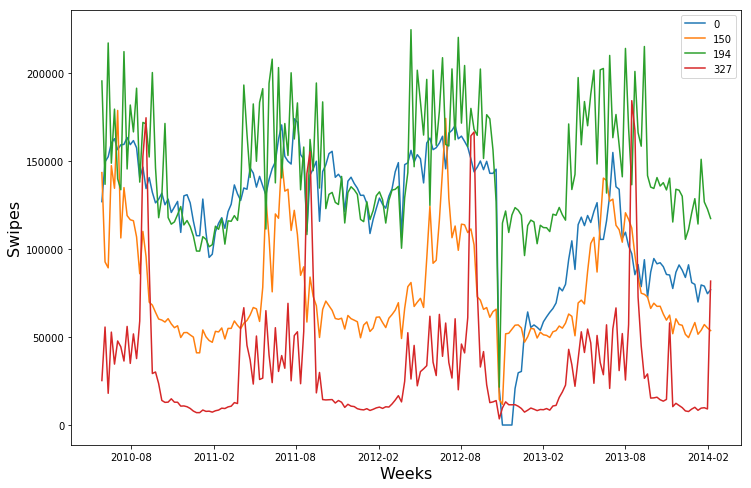

In [22]:
# plot swipes time series for the top 4 stations
fig=pl.figure(figsize=(12,8))
ax=fig.add_subplot(111)
for p in peak:
    pl.plot(weeks, df3[p], label=p)

pl.xlabel('Weeks', fontsize=16)
pl.ylabel('Swipes', fontsize=16)
pl.legend()

## Results
### Station indices (axis=0 in datacube) with prominent annual periodicity (top peaks around 52 week):
- 0
- 150
- 194
- 327

### Peaks happen during summer. A possible hypothesis is that these are stations near popular points of interest that draw a lot of tourists in summer vacation.

# Extra Credit: Time Series Clustering
## Identify groups of time series that look similar among each other.

KMeans or PCA

sklearn.cluster

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

```
km.fit(vals)
```